In [134]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [135]:

class Value:
  def __init__(self, data, _children = (), _op = '', label = ''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self) -> str:
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out
  def __radd__(self, other):
    return self + other

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad += (other * self.data**(other - 1)) * out.grad
    out._backward = _backward

    return out

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    X = self.data
    out = Value(math.exp(X), (self, ), '')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):
    self.grad = 1.0

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)
    for node in reversed(topo):
      node._backward()



In [136]:
from graphviz import Digraph

In [137]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges


def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for
    # it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data,n.grad), shape = 'record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  return dot




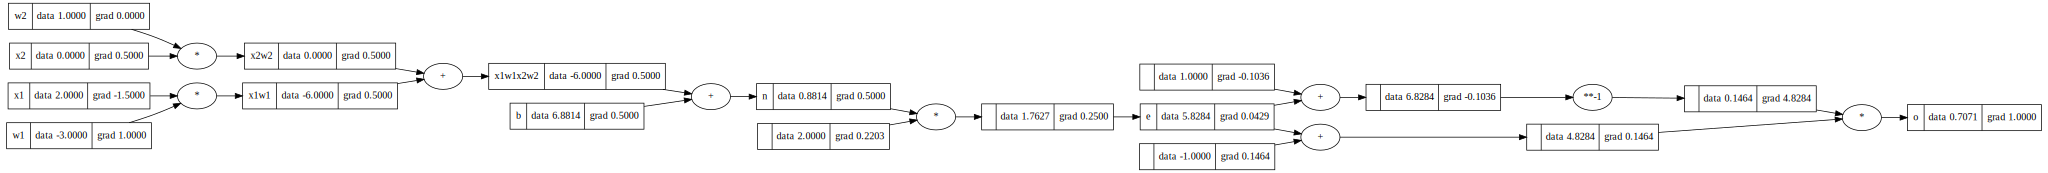

In [138]:
# inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

# weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# bias of the neuron
b = Value(6.8813735870195432, label = 'b')

# x1w1 + x2w2 + b
x1w1 =  x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# ______________________________________________________________________________
e = (2*n).exp(); e.label = 'e'
o = (e - 1)/(e + 1); o.label = 'o'

# __________________________________________________

o.backward()
draw_dot(o)



In [139]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.tensor([1.0]).double(); w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())


0.7071066904050358
---
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [140]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters() ]

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]




In [165]:
n = MLP(3,[4,4,1])

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [229]:
for k in range(20):

  #  forward pass
  ypred  = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(f'epoch {k} loss {loss.data}')



epoch 0 loss 2.8502413603095192e-05
epoch 1 loss 1.8854399553997968e-08
epoch 2 loss 9.485845410540548e-10
epoch 3 loss 2.7584287779469174e-06
epoch 4 loss 3.9774098797367277
epoch 5 loss 5.362123179314591e-09
epoch 6 loss 1.9405482148036423e-19
epoch 7 loss 7.092089058249865e-23
epoch 8 loss 2.125283107005154e-25
epoch 9 loss 7.545454558438978e-28
epoch 10 loss 2.5637979419682884e-30
epoch 11 loss 0.0
epoch 12 loss 0.0
epoch 13 loss 0.0
epoch 14 loss 0.0
epoch 15 loss 0.0
epoch 16 loss 0.0
epoch 17 loss 0.0
epoch 18 loss 0.0
epoch 19 loss 0.0


In [230]:
ypred

[Value(data=1.0), Value(data=-1.0), Value(data=-1.0), Value(data=1.0)]

[Value(data=0.9995925712526735),
 Value(data=-0.9978743267206823),
 Value(data=-0.9916464397414229),
 Value(data=0.9995768527036275)]

In [100]:
def lol():
  h = 0.0001
  a = Value(5.0, label= 'a')
  b = Value(3.0, label= 'b')
  c = Value(2.0, label = 'c')
  e = a * b ; e.label = 'e'
  d = e + c ; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d * f ; L.label = 'L'

  L1 = L.data

  a = Value(5.0 , label= 'a')
  b = Value(3.0, label= 'b')
  c = Value(2.0, label = 'c')
  e = a * b ; e.label = 'e'
  d = e + c ; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d * f + h; L.label = 'L'

  L2 = L.data

  print((L2 - L1)/h)
  draw_dot(L)

  # (a.__mul__(b)).__add__(c)

lol()

1.0000000000331966


In [51]:
# o.grad = 1.0

In [52]:
# o._backward()
# n._backward()
# x1w1x2w2._backward()
# b._backward()
# x1w1._backward()
# x2w2._backward()

In [24]:
# o.grad = 1.0
# n.grad = 1 - o.data**2
# x1w1x2w2.grad = n.grad
# b.grad = n.grad
# x1w1.grad = x1w1x2w2.grad
# x2w2.grad = x1w1x2w2.grad
# x1.grad = w1.data * x1w1.grad
# x2.grad = w2.data * x2w2.grad
# w1.grad = x1.data * x1w1.grad
# w2.grad = x2.data * x2w2.grad
